# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams

from src.model.functions import train_and_evaluate_iforest

## General parameters

In [5]:
n_iter_fs = 1
n_iter = 1
contamination_percentage = [1] 
trees = [100]

## Data-set

In [6]:
dataset_id = 'allianz'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(42358, 26)

In [7]:
excluded_cols = []

### iForest

## Parameters

In [8]:
# path
path = os.path.join(data_root, "outputs", f"{dataset_id}_results_if.parquet")
path

'/Users/allianz/workspace_github_pers/ad_shap_stability/test/data/outputs/allianz_results_if.parquet'

In [9]:
hyper = fs_datasets_hyperparams(dataset_id)
hyper

{'contamination': 0.1, 'max_samples': 256, 'n_estimators': 100}

### Iforest full features

In [10]:
# Capture the start time
start_time = datetime.datetime.now()

df = train_and_evaluate_iforest(data, dataset_id=dataset_id, hyper=hyper, n_tree_estimators=trees, contamination_percentage=contamination_percentage, excluded_cols=excluded_cols, n_iter_fs=n_iter_fs, n_iter=n_iter)

# Capture the finish time
finish_time = datetime.datetime.now()

# Calculate the duration
duration = finish_time - start_time

print(f"Duration: {duration}")


Iteration by tree number: 100
  Iteration by contamination: 0.1
    Number of featured: 26
     Iteration by feat number: 5
     Iteration by feat number: 10
     Iteration by feat number: 15
     Iteration by feat number: 20
     Iteration by feat number: 26
Duration: 0:12:19.546243


In [11]:
df.head()

,f1-score,recall,precision,roc_auc,stab_model,stab_model_list,stab_shap,stab_shap_list,n_estimators,max_feats,contamination,n_feats,n_iter,n_iter_fs
0,0.178317,0.107560,0.521143,0.497510,0.985811,"[[0.9999999255368747, 0.9999999557421454, 0.99...","[0.9831567294240584, 0.9745837669395404, 0.972...","[[0.9955360952319826, 0.9905931939040292, 0.99...",100,5,0.1,26,1,1
1,0.175977,0.106263,0.511641,0.497582,0.989226,"[[0.9999999237106482, 0.9999988185447325, 0.99...","[0.9654011275624347, 0.9783529478780991, 0.971...","[[0.9939200692367388, 0.9564315756880117, 0.99...",100,10,0.1,26,1,1
2,0.176275,0.106027,0.522371,0.499051,0.989061,"[[0.9999997179557393, 0.9999999944646311, 0.99...","[0.9767896065449733, 0.9667771186813603, 0.968...","[[0.9961840291598203, 0.9741512913188628, 1.0,...",100,15,0.1,26,1,1
3,0.174907,0.105555,0.509972,0.499176,0.988425,"[[0.9999999999411924, 0.9999999957749511, 0.99...","[0.9598832633462187, 0.9670063522079528, 0.955...","[[0.9884825658027689, 0.9505629087297339, 0.99...",100,20,0.1,26,1,1
4,0.177860,0.107442,0.516147,0.499736,0.983070,"[[0.9999999910435119, 0.9999999703133772, 0.99...","[0.9592337715744246, 0.9617386572998943, 0.968...","[[0.9936935837354532, 0.9232682537643557, 1.0,...",100,26,0.1,26,1,1


In [12]:
def process_data(df):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics.
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """
    # Filter dataframe
    
    # Calculate percentiles and stability index
    df['shap_q1'] = df['stab_shap'].apply(lambda x: np.percentile(x, 75))
    df['shap_q2'] = df['stab_shap'].apply(lambda x: np.percentile(x, 50))
    df['shap_q3'] = df['stab_shap'].apply(lambda x: np.percentile(x, 25))
    df['stability index'] = df['stab_shap'].apply(lambda x: np.mean(x))

    return df

In [13]:
test = process_data(df)
test = test[(test.n_estimators==100) & (test.n_feats==test.n_feats.max()) & (test.max_feats==test.max_feats.max())]
test

,f1-score,recall,precision,roc_auc,stab_model,stab_model_list,stab_shap,stab_shap_list,n_estimators,max_feats,contamination,n_feats,n_iter,n_iter_fs,shap_q1,shap_q2,shap_q3,stability index
4,0.17786,0.107442,0.516147,0.499736,0.98307,"[[0.9999999910435119, 0.9999999703133772, 0.99...","[0.9592337715744246, 0.9617386572998943, 0.968...","[[0.9936935837354532, 0.9232682537643557, 1.0,...",100,26,0.1,26,1,1,0.958259,0.947256,0.936217,0.946755


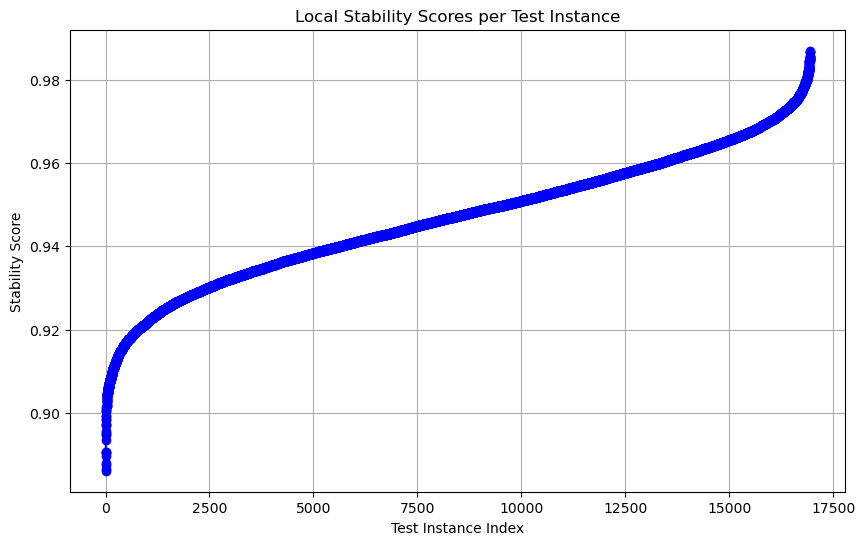

In [14]:
import matplotlib.pyplot as plt

# Assuming `final_stability_score` is your array of stability scores from the modified function
stability_scores = np.array(test.stab_shap)[0]
stability_scores = np.sort(stability_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stability_scores, marker='o', linestyle='-', color='blue')
plt.title('Local Stability Scores per Test Instance')
plt.xlabel('Test Instance Index')
plt.ylabel('Stability Score')
plt.grid(True)
plt.show()

In [15]:
from src.plots.functions import plot_3d_surface, plot_2d_surface, boxplot_stability, lineplot_stability

In [16]:
test

,f1-score,recall,precision,roc_auc,stab_model,stab_model_list,stab_shap,stab_shap_list,n_estimators,max_feats,contamination,n_feats,n_iter,n_iter_fs,shap_q1,shap_q2,shap_q3,stability index
4,0.17786,0.107442,0.516147,0.499736,0.98307,"[[0.9999999910435119, 0.9999999703133772, 0.99...","[0.9592337715744246, 0.9617386572998943, 0.968...","[[0.9936935837354532, 0.9232682537643557, 1.0,...",100,26,0.1,26,1,1,0.958259,0.947256,0.936217,0.946755


{'whiskers': [<matplotlib.lines.Line2D at 0x16c3517c0>,
 'caps': [<matplotlib.lines.Line2D at 0x16c351d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x16c351520>],
 'medians': [<matplotlib.lines.Line2D at 0x16c361280>],
 'fliers': [<matplotlib.lines.Line2D at 0x16c361520>],
 'means': []}

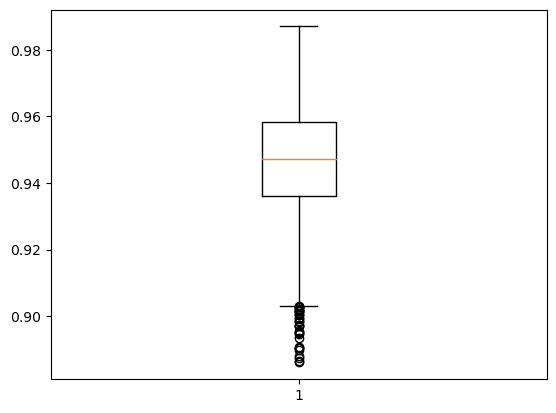

In [17]:
plt.boxplot(test.stab_shap)